In [88]:
import pandas as pd
import os; os.getcwd()
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [163]:
# Load pandas from zip
df = (
    pd.read_stata("data/full_panel.zip")
    )

# Drop if don't show up in all 3 waves
trajectories = (
    df
    .query("crop_code == 'MAIZE'")
    .dropna(subset= ['impmaize'])
    .groupby(['holder_id', 'parcel_id', 'field_id'])['impmaize']
    .agg(trajectories = list)
    .assign(len_traj = lambda df: df['trajectories'].apply(lambda x: len(x)))
    .query("len_traj == 3")
    .drop(['len_traj'], axis=1)
    )

# Merge back
balanced_panel_df = df.merge(trajectories, on = ['holder_id'])

balanced_panel_df[["LAT_DD_MOD", "LON_DD_MOD"]] = balanced_panel_df.groupby('holder_id')[["LAT_DD_MOD", "LON_DD_MOD"]].transform('mean')


/usr/lib/python3.9/site-packages/pandas/io/stata.py:1457: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


## Create Map of Households

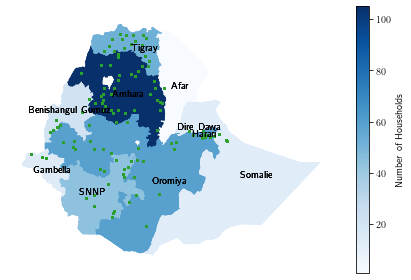

In [196]:
map = gpd.read_file("data/ethiopiaworeda/Eth_Woreda_2013.shp").replace({'REGIONNAME' : {'Beneshangul Gumu' : 'Benishangul Gumuz',
                                                                                       'Hareri' : 'Harari',
                                                                                       'SNNPR' : 'SNNP',
                                                                                       'Oromia' : 'Oromiya',
                                                                                       'Somali' : 'Somalie',
                                                                                       'Gambela' : 'Gambella'}})

# Get number of households per region
hhids = balanced_panel_df.drop_duplicates(['holder_id', 'wave']).groupby(['region', 'wave'])['holder_id'].count()

fig, ax = plt.subplots()

ax.set_axis_off()

with mpl.rc_context(rc={'text.usetex': True}):
    merged_map = (
        map
        .dissolve('REGIONNAME')
        .merge(hhids, 
               left_index=True, 
               right_on = ['region'])
        .reset_index('region')
        .to_crs(epsg= 4326)
    )
    
    merged_map.plot(column='holder_id',
                    legend=True,
                    legend_kwds={'label' : "Number of Households"},
                ax=ax,
                cmap = 'Blues',
                missing_kwds={'color': 'lightgrey'})
    
    merged_map.apply(lambda x: ax.annotate(text=x['region'], xy=x.geometry.representative_point().coords[0], ha='center'), axis=1)
    
    panel_gdf = gpd.GeoDataFrame(balanced_panel_df, geometry=gpd.points_from_xy(balanced_panel_df["LON_DD_MOD"], balanced_panel_df["LAT_DD_MOD"]), crs=4326).plot(color='tab:green', ax=ax, markersize=4)


    plt.tight_layout()

    plt.savefig("results/figures/map_hhids.pdf", format='pdf', dpi=160)

## Create Summary Table

In [290]:
def add_note(table, note, n):
    
    return table.replace("\\end{tabular}\n\\end{table}", f"\\multicolumn{{{n}}}{{l}}{{Note: {note}}}\n\\end{{tabular}}\n\\end{{table}}")

summary_latex = (
    balanced_panel_df
    .assign(dirrigation_codes = lambda df: df['dirrigation'].cat.codes.where(lambda x: x>=0))
    [['parcesizeHA_wiz', 
                       'hhlabor', 
                       'hiredlabor', 
                       'age_head_wiz', 
                       'dist_road_wiz', 
                       'dist_popcenter_wiz',
                       'dist_market_wiz',
                       'dist_borderpost_wiz',
                       'dist_admctr_wiz',  
                       'fertcosts',
                       'dirrigation_codes',
                       'numadult',
                       'numwomen',
                       'numchildren',
                       'YIELD_cropcutfresh_tr',
                       'YIELD_cropcutdry_tr',
                       'YIELD_selfr_tr'
                       ]]
    .describe()
    .T[['count', 'mean', 'std', 'min', 'max']]
    .rename({'count' : 'N', 'mean' : 'Mean', 'std' : 'Std. Dev.', 'min' : 'Min', 'max' : 'Max'}, axis=1)
    .rename({'parcesizeHA_wiz' : 'Parcel Size',
              'hhlabor' : 'Household Labor for Harvest (Days)',
              'hiredlabor' : 'Hired Labor for Harvest (Days)',
              'age_head_wiz' : 'Age of Household Head',
              'dist_road_wiz' : 'Distance to Nearest Asphalt Road (km)',
              'dist_borderpost_wiz' : 'Distance to Nearest Border (km)',
              'dist_market_wiz' : 'Distance to Nearest Market (km)',
              'dist_popcenter_wiz' : 'Distance to Nearest Population Center (km)',
              'dist_admctr_wiz' : 'Distance to Nearest Administrative Center (km)',
              'fertcosts' : 'Fertilizer Costs',
              'dirrigation_codes' : 'Do you irrigate?',
              'numadult' : 'Number of Adults',
              'numwomen' : 'Number of Women',
              'numchildren' : 'Number of Children',
              'YIELD_cropcutfresh_tr' : 'Crop Cut Fresh Yield (kg/ha)',
            'YIELD_cropcutdry_tr' : 'Crop Cut Dry Yield (kg/ha)',
            'YIELD_selfr_tr' : 'Self-reported Yields (kg/ha)'
              })
    .style.format("{:,.2f}".format)
    .to_latex(label = "tbl:summary",
              caption="Summary Statistics for Households",
              hrules=True)
    )

with open("results/tables/summary.tex", 'w') as f:
    f.write(add_note(summary_latex, 'Parcel size, yield and distance variables winsorized at the 1\% level.', 6))

In [267]:
balanced_panel_df.columns[balanced_panel_df.columns.str.contains("YIELD")]

Index(['YIELD_cropcutfresh', 'YIELD_cropcutdry', 'YIELD_cropcutfresh_tr',
       'YIELD_cropcutdry_tr', 'YIELD_selfr', 'YIELD_selfr_tr'],
      dtype='object')